In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import sys
import os
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('../'))

from src.tabddpm.hyperparameter_tuning import hyperparameter_search
from src.tabddpm.training import Trainer, get_diffusion_model
from src.tabddpm.denoising_model import MLPDenoiser
from src.tabddpm.evaluate import evaluate_mixed_loss


In [46]:
file_path = 'data/preprocessed/1480/data_processed.csv'

df = pd.read_csv(file_path)

df.head()


,V1,V10,V3,V4,V5,V6,V7,V8,V9,V2
0,1.190940,-0.151318,-1.016737,-5.199338,-0.444948,-1.411573,-1.350125,0.188461,0.212631,0.0
1,1.020355,-0.645041,1.405765,1.423335,1.646522,0.740885,0.801780,0.970866,0.110048,1.0
2,1.020355,-0.283710,1.235902,1.288435,1.231294,0.655684,0.493028,0.440198,0.212631,1.0
3,0.707298,0.270284,0.000000,0.116550,-0.534807,-1.746316,-1.144112,0.188461,0.306203,1.0
4,1.672115,-1.991811,0.930265,0.926951,-0.245794,-0.400208,0.376984,0.792902,-0.907275,1.0


In [47]:
df.shape

(583, 10)

In [48]:
num_numerical = 9
num_classes=[2]
d_in = num_numerical + sum(num_classes)

X = torch.tensor(df.values, dtype=torch.float32)
batch_size = 32
data_loader = DataLoader(TensorDataset(X), batch_size=batch_size, shuffle=True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
search_space = {
    'd_layers': [[128, 128], [256, 128, 64], [264, 264, 264], [512, 256, 128]],
    'dropout': [0.0, 0.1],
    'd_t': [64, 128],
    'lr': [1e-3, 5e-4]
}

best_config, best_model_state, best_loss, best_loss_random = hyperparameter_search(
    data_loader=data_loader,
    num_classes=num_classes,  # replace with your dataset
    num_numerical=num_numerical,
    device=device,
    steps=1000,
    search_space=search_space
)

print("✅ Best config:", best_config)
print("📉 Best loss:", best_loss)
print("📉 Random loss:", best_loss_random)




🔍 Trying config: {'d_layers': [128, 128], 'dropout': 0.0, 'd_t': 64, 'lr': 0.001}
[0/1000] Loss: 2.6672
[100/1000] Loss: 1.4389
[200/1000] Loss: 1.2195
[300/1000] Loss: 1.1300
[400/1000] Loss: 1.0610
[500/1000] Loss: 1.1779
[600/1000] Loss: 2.3323
[700/1000] Loss: 0.8140
[800/1000] Loss: 0.7096
[900/1000] Loss: 0.8049
Validation Loss: 0.9948, Random Loss: 3.0596

🔍 Trying config: {'d_layers': [128, 128], 'dropout': 0.0, 'd_t': 64, 'lr': 0.0005}
[0/1000] Loss: 3.7010
[100/1000] Loss: 1.4331
[200/1000] Loss: 1.0885
[300/1000] Loss: 1.4492
[400/1000] Loss: 1.2430
[500/1000] Loss: 1.0003
[600/1000] Loss: 0.8325
[700/1000] Loss: 1.2379
[800/1000] Loss: 2.4602
[900/1000] Loss: 1.2224
Validation Loss: 0.9581, Random Loss: 2.7041

🔍 Trying config: {'d_layers': [128, 128], 'dropout': 0.0, 'd_t': 128, 'lr': 0.001}
[0/1000] Loss: 3.2044
[100/1000] Loss: 1.6342
[200/1000] Loss: 1.5229
[300/1000] Loss: 1.1891
[400/1000] Loss: 1.1612
[500/1000] Loss: 0.7607
[600/1000] Loss: 1.2317
[700/1000] Loss: 

In [116]:
d_layers = [264, 264, 264]
dropout = 0.0
d_t = 32
steps = 1000
lr = 1e-3
random_loss = 2.7932

In [119]:
model = MLPDenoiser(
    d_in=d_in,
    d_layers=d_layers,
    dropout=dropout,
    d_t=d_t
).to(device)

# Wrap with diffusion model
diffusion = get_diffusion_model(model, num_classes, num_numerical, device)

# Train
trainer = Trainer(diffusion, data_loader, device, steps=steps, lr=lr)
losses, overall_losses = trainer.train()

[0/1000] Loss: 1.6440
[100/1000] Loss: 1.0824
[200/1000] Loss: 1.3537
[300/1000] Loss: 1.0810
[400/1000] Loss: 1.0600
[500/1000] Loss: 1.0672
[600/1000] Loss: 1.1389
[700/1000] Loss: 1.6094
[800/1000] Loss: 0.7999
[900/1000] Loss: 0.9039


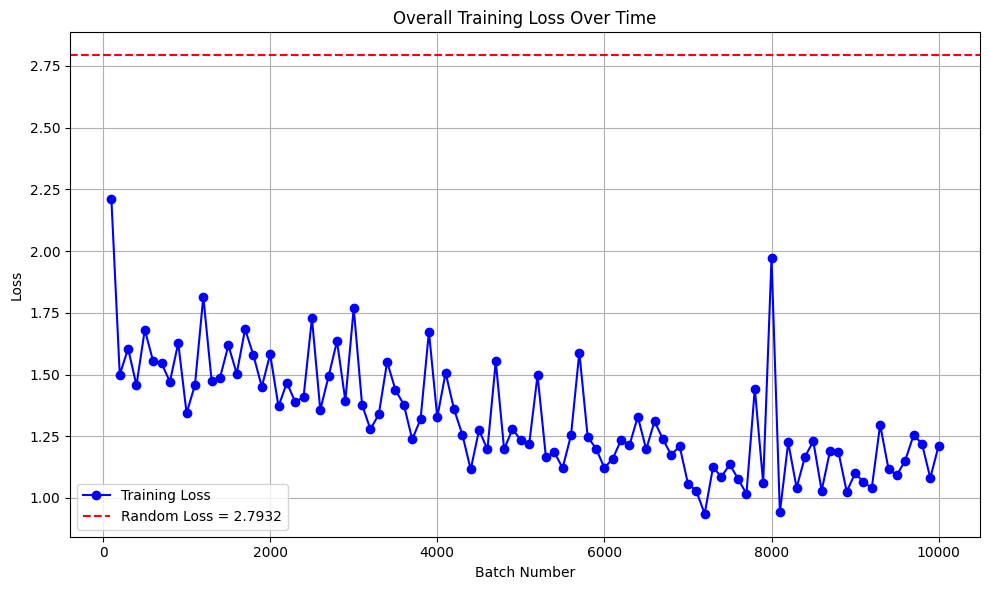

In [126]:
overall_losses_sub = [overall_losses[i] for i in range(0,len(overall_losses), 10)]

x = [100 * (i + 1) for i in range(len(overall_losses_sub))]  # e.g., [100, 200, 300, ...]

plt.figure(figsize=(10, 6))
plt.plot(x, overall_losses_sub, label="Training Loss", color="blue", marker='o')
plt.axhline(y=random_loss, color="red", linestyle="--", label=f"Random Loss = {random_loss:.4f}")

plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.title("Overall Training Loss Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


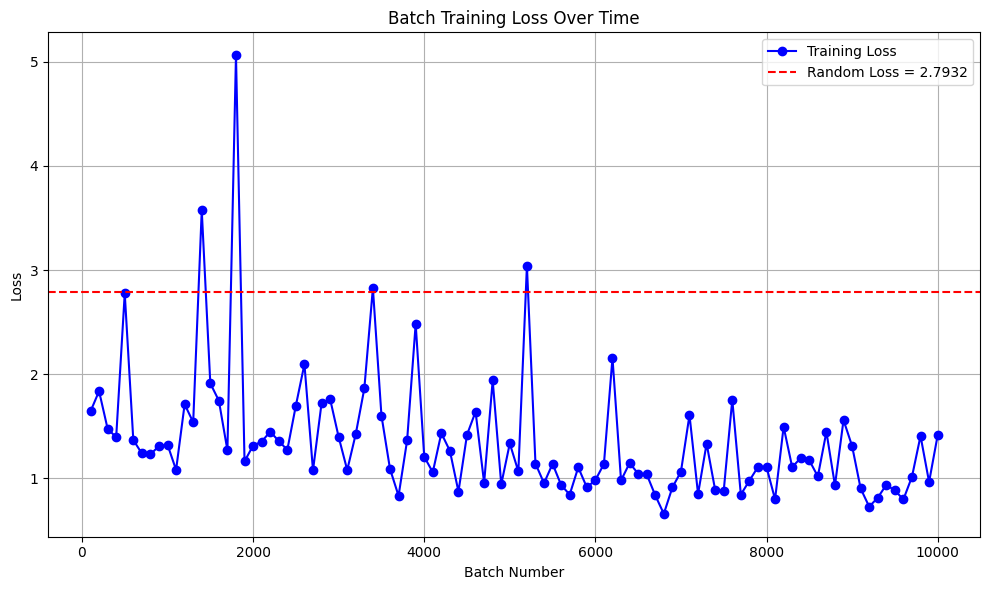

In [125]:
losses_sub = [losses[i] for i in range(0,len(losses), 10)]

x = [100 * (i + 1) for i in range(len(losses_sub))]  # e.g., [100, 200, 300, ...]

plt.figure(figsize=(10, 6))
plt.plot(x, losses_sub, label="Training Loss", color="blue", marker='o')
plt.axhline(y=random_loss, color="red", linestyle="--", label=f"Random Loss = {random_loss:.4f}")

plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.title("Batch Training Loss Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
